# Import necessary libraries


In [368]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_absolute_error


from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

# Load the dataset


In [369]:
# Load the dataset
file_path = 'ETTh1_without_missing.csv'
data = pd.read_csv(file_path)


# Parse the 'date' column as datetime
data['date'] = pd.to_datetime(data['date'])

# Set the 'date' column as the index
data.set_index('date', inplace=True)

# Drop unnecessary columns
data.drop(['Id', 'Unnamed: 3'], axis=1, inplace=True)
data.describe()



,OT
count,17320.000000
mean,13.352560
std,8.582739
min,-4.080000
25%,6.964000
50%,11.467000
75%,18.150000
max,46.007000


In [370]:


# Filtering the dataframe to remove outliers

# Displaying the first few rows of the new dataframe without outliers
df = data[(data['OT'] <= 25) & (data['OT'] >= 0)]
df

,OT
date,
2016-07-01 04:00:00,21.948000
2016-07-01 05:00:00,21.174000
2016-07-01 06:00:00,22.792000
2016-07-01 07:00:00,23.143999
2016-07-01 08:00:00,21.667000
...,...
2018-06-22 11:00:00,6.753000
2018-06-22 12:00:00,3.658000
2018-06-22 13:00:00,3.658000


# Drop unnecessary columns and convert 'date' to datetime format


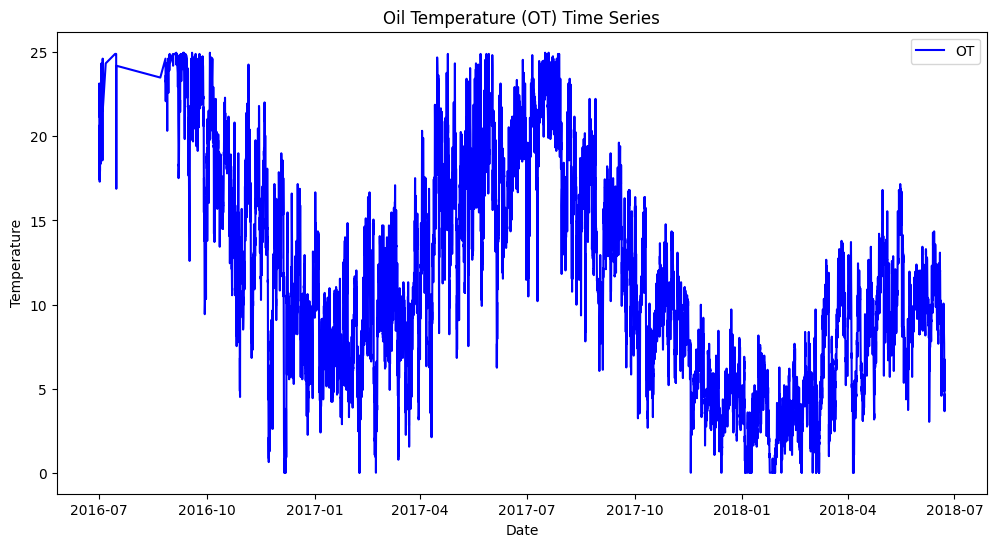

In [371]:

# Visualize the 'OT' time series
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['OT'], label='OT', color='blue')
plt.title('Oil Temperature (OT) Time Series')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

#WE ARE PLOTTNG WITH A ROLLING TO SEE IF THERE'S A TREND AND DECIDED IF DATA'S SHOULD BE NORMALIZED OR NOT


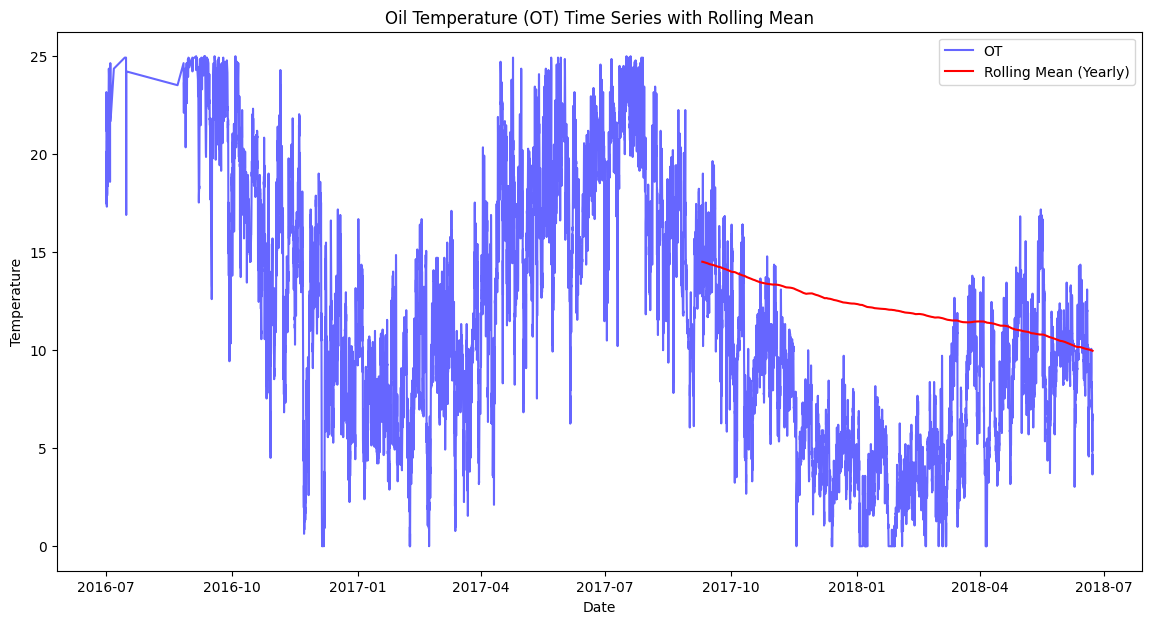

In [372]:
# Plotting the "OT" time series again with a rolling mean to identify trends
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['OT'], label='OT', color='blue', alpha=0.6)
plt.plot(df['OT'].rolling(window=365*24).mean(), label='Rolling Mean (Yearly)', color='red')
plt.title('Oil Temperature (OT) Time Series with Rolling Mean')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [373]:
# Normalize the 'OT' column
scaler = MinMaxScaler()
df['OT_normalized'] = scaler.fit_transform(df[['OT']])


/var/folders/nd/zqzyx7f11f39z7k57jd4z3sh0000gn/T/ipykernel_95281/3892689744.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['OT_normalized'] = scaler.fit_transform(df[['OT']])


In [374]:
df.tail(100)

,OT,OT_normalized
date,,
2018-06-18 12:00:00,10.833,0.433789
2018-06-18 13:00:00,11.185,0.447884
2018-06-18 14:00:00,11.959,0.478877
2018-06-18 15:00:00,13.085,0.523966
2018-06-18 16:00:00,11.959,0.478877
...,...,...
2018-06-22 11:00:00,6.753,0.270412
2018-06-22 12:00:00,3.658,0.146478
2018-06-22 13:00:00,3.658,0.146478


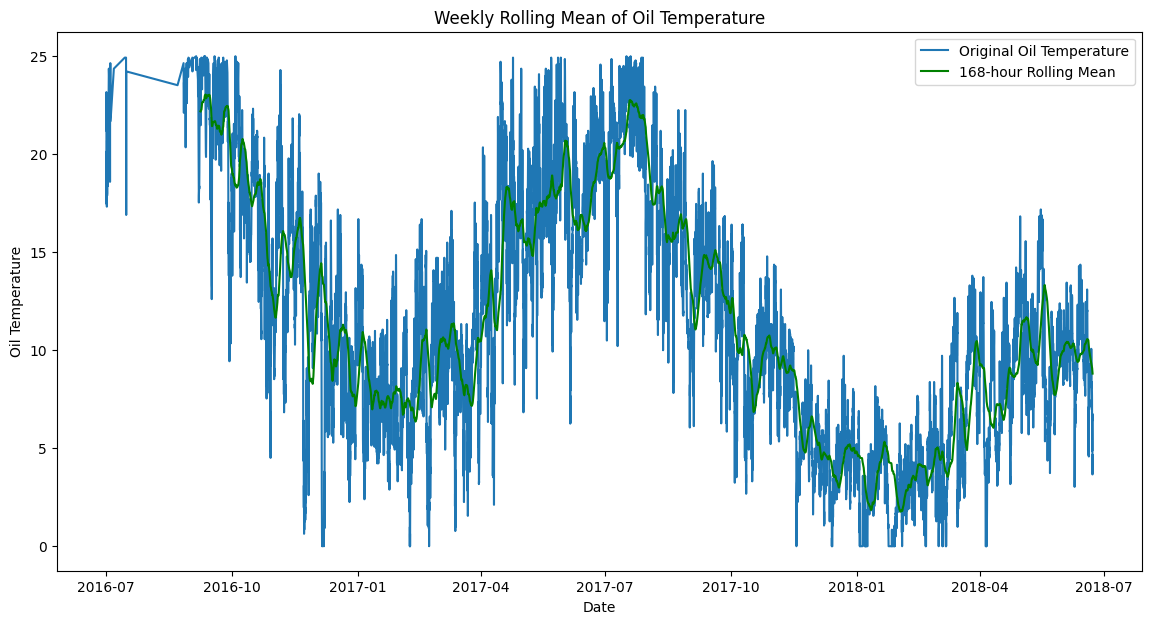

In [375]:
roll_mean_weekly = df['OT'].rolling(window=168).mean()

plt.figure(figsize=(14, 7))
plt.plot(df['OT'], label='Original Oil Temperature')
plt.plot(roll_mean_weekly, color='green', label='168-hour Rolling Mean')
plt.title('Weekly Rolling Mean of Oil Temperature')
plt.xlabel('Date')
plt.ylabel('Oil Temperature')
plt.legend()
plt.show()


In [376]:
 #Function to create sequences from the time series data
def create_sequences(input_data, window_size):
    X = []
    Y = []
    for i in range(len(input_data) - window_size):
        X.append(input_data[i:(i + window_size), 0])
        Y.append(input_data[i + window_size, 0])
    return np.array(X), np.array(Y)

In [377]:
# Prepare sequences using the normalized 'OT' values
window_size = 5
X, Y = create_sequences(df[['OT_normalized']].values, window_size)

In [378]:

# Split the data into training and test sets (excluding the last 100 values for testing)
X_train = X[:-100]
Y_train = Y[:-100]
X_test = X[-100:]
Y_test = Y[-100:]

In [379]:
# Reshape input for LSTM [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], window_size, 1))
X_test = X_test.reshape((X_test.shape[0], window_size, 1))

In [380]:
from tensorflow.keras.layers import Dropout  #Build the LSTM model
model = Sequential([
    LSTM(256, return_sequences=True, input_shape=(window_size, 1)), # 'window_size' and the last dimension '1' should match your data shape
    Dropout(0.4),  # Dropout layer after the first LSTM layer
    LSTM(128),  # Second LSTM layer, could adjust the number of units
    Dropout(0.2),  # Dropout layer after the second LSTM layer
    Dense(1)  # Output layer that predicts the future value
])


/Users/thiamaziz/Desktop/forecasting/forecasting/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [381]:
 #Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError(), metrics=[RootMeanSquaredError()])


In [382]:

# (Optional) Print model summary to verify architecture
model.summary()


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_30 (LSTM)                  │ (None, 5, 256)         │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 5, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_31 (LSTM)                  │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 461,441 (1.76 MB)

 Trainable params: 461,441 (1.76 MB)

 Non-trainable params: 0 (0.00 B)

In [391]:
# Train the model
model.fit(X_train, Y_train, validation_split=0.1, epochs=27, batch_size=64)

Epoch 1/27
217/217 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0017 - root_mean_squared_error: 0.0417 - val_loss: 6.8026e-04 - val_root_mean_squared_error: 0.0266
Epoch 2/27
217/217 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0017 - root_mean_squared_error: 0.0407 - val_loss: 6.8974e-04 - val_root_mean_squared_error: 0.0267
Epoch 3/27
217/217 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0017 - root_mean_squared_error: 0.0409 - val_loss: 6.9564e-04 - val_root_mean_squared_error: 0.0269
Epoch 4/27
217/217 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0017 - root_mean_squared_error: 0.0411 - val_loss: 7.2080e-04 - val_root_mean_squared_error: 0.0274
Epoch 5/27
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0016 - root_mean_squared_error: 0.0406 - val_loss: 7.5377e-04 - val_root_mean_squared_error: 0.0279
Epoch 6/27
217/217 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0016 - root_mean_squared_error: 0.0406 - val_loss: 7.1626e-04 - val_root_mean_squared_error: 0.0272
Epoch 7/27
217/217 ━━━

In [392]:
# After training,evaluate the model
model.evaluate(X_test, Y_test) 

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015 - root_mean_squared_error: 0.0349 


[0.001970288110896945, 0.03432166576385498]

In [393]:
model.predict(X_test)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


array([[0.41142422],
       [0.4395875 ],
       [0.45475724],
       [0.4860113 ],
       [0.5299157 ],
       [0.4916384 ],
       [0.49209782],
       [0.48910996],
       [0.48370638],
       [0.43894857],
       [0.41979042],
       [0.41394335],
       [0.419664  ],
       [0.40187213],
       [0.38030374],
       [0.37726066],
       [0.37184083],
       [0.36939225],
       [0.37366545],
       [0.3921452 ],
       [0.38874742],
       [0.3738765 ],
       [0.38176915],
       [0.39760458],
       [0.40250105],
       [0.41315895],
       [0.40081495],
       [0.25962305],
       [0.24193975],
       [0.19847563],
       [0.22143981],
       [0.26802737],
       [0.2779631 ],
       [0.29258698],
       [0.20746845],
       [0.21654822],
       [0.23840225],
       [0.26840478],
       [0.29788083],
       [0.2883526 ],
       [0.29305774],
       [0.29176134],
       [0.29281223],
       [0.2999397 ],
       [0.30570126],
       [0.2942545 ],
       [0.3055274 ],
       [0.328

In [394]:
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, Y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=0  # Set verbose to 1 or 2 to see the training progress
)

# Make predictions on the test data
predictions = model.predict(X_test)

# Inverse transform the predictions and the actual Y_test values to their original scale
predictions_inverse = scaler.inverse_transform(predictions)
Y_test_inverse = scaler.inverse_transform(Y_test.reshape(-1, 1))

# Prepare data for plotting
preds = predictions_inverse.flatten()
actuals = Y_test_inverse.flatten()

(preds[:10], actuals[:10])  # Display the first 10 predictions and actual values for comparison


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


(array([10.081113, 10.796844, 11.159731, 11.936174, 13.028643, 11.995364,
        12.043898, 11.998122, 11.866592, 10.709946], dtype=float32),
 array([10.83300018, 11.18500042, 11.95899963, 13.08500004, 11.95899963,
        12.02900028, 12.02900028, 11.81799984, 10.62199974, 10.19999981]))

In [395]:
test_dates = df.index[-100:]  # Assuming 'df' has 'date' set as its index

# Create a DataFrame for comparing predictions with actual values
comparison_df = pd.DataFrame({
    'date': test_dates,
    'Actual': actuals,  # 'actuals' needs to be defined previously
    'Predicted': preds  # 'preds' needs to be defined previously
})

# Display the DataFrame
comparison_df.to_csv('comparaison.csv',index=False)
comparison_df


,date,Actual,Predicted
0,2018-06-18 12:00:00,10.833,10.081113
1,2018-06-18 13:00:00,11.185,10.796844
2,2018-06-18 14:00:00,11.959,11.159731
3,2018-06-18 15:00:00,13.085,11.936174
4,2018-06-18 16:00:00,11.959,13.028643
...,...,...,...
95,2018-06-22 11:00:00,6.753,6.454867
96,2018-06-22 12:00:00,3.658,6.918446
97,2018-06-22 13:00:00,3.658,4.230704
98,2018-06-22 14:00:00,4.150,4.029953


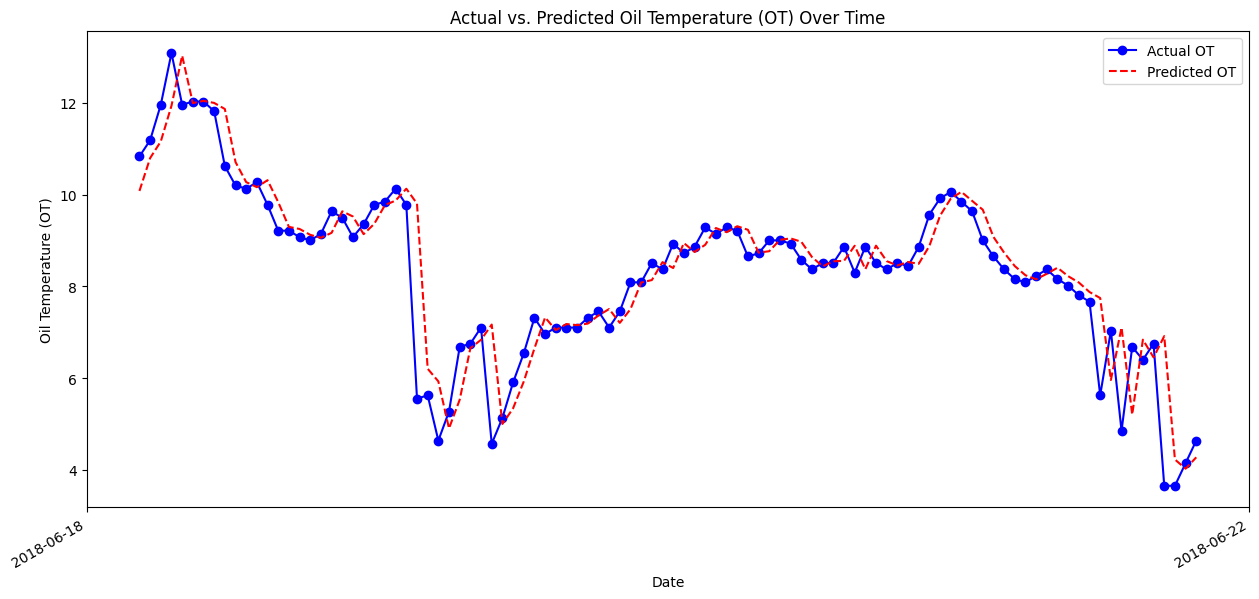

In [396]:

# Sample DataFrame 'comparison_df' columns: 'Date', 'Actual', 'Predicted'
# Ensure 'Date' is in datetime format; if not, convert it
comparison_df['date'] = pd.to_datetime(comparison_df['date'])

# Plotting
plt.figure(figsize=(15, 7))  # Set the figure size for better readability
plt.plot(comparison_df['date'], comparison_df['Actual'], label='Actual OT', color='blue', marker='o')
plt.plot(comparison_df['date'], comparison_df['Predicted'], label='Predicted OT', color='red', linestyle='--')

# Formatting the plot
plt.title('Actual vs. Predicted Oil Temperature (OT) Over Time')
plt.xlabel('Date')
plt.ylabel('Oil Temperature (OT)')
plt.legend()

# Improve date formatting on x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))  # Adjust interval for better readability
plt.gcf().autofmt_xdate()  # Rotate date labels for better readability

plt.show()


In [397]:
mae = mean_absolute_error(actuals, preds)

print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 0.4787736320495604


In [398]:

# Function to make future predictions, returning both the scaled and original values
def make_future_predictions(model, scaler, last_window, future_steps=100):
    future_preds_scaled = []
    current_step = last_window
    
    for _ in range(future_steps):
        # Predict the next step
        next_step_pred = model.predict(current_step.reshape((1, window_size, 1)))
        future_preds_scaled.append(next_step_pred.flatten()[0])
        
        # Update the current step to include the prediction
        current_step = np.roll(current_step, -1, axis=0)
        current_step[-1] = next_step_pred
        
    # Inverse transform to get predictions back to their original scale
    future_preds = scaler.inverse_transform(np.array(future_preds_scaled).reshape(-1, 1)).flatten()
    
    return future_preds

# Assuming df['OT_normalized'] and scaler are already defined
window_size = 5  # This should match the window_size used during training
last_window = df['OT_normalized'].values[-window_size:]

# Generate the next 100 future predictions
future_predictions = make_future_predictions(model, scaler, last_window, future_steps=100)

# Create a DataFrame for the predictions with an ID column starting at 0
future_df = pd.DataFrame({
    'Id': range(0, 100),  # Generate IDs from 0 to 99
    'OT': future_predictions
})

# Display the first few rows to verify
print(future_df.head())

# Save the future predictions to a CSV file
future_df.to_csv('future_ot_predictions.csv', index=False)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


/var/folders/nd/zqzyx7f11f39z7k57jd4z3sh0000gn/T/ipykernel_95281/1095223485.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_step[-1] = next_step_pred


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/s